In [ ]:
from 

## Experiment 3 - Layer anaylsis 

Question 3: Does Cot vs. std prompt change ranking of the answer throughout the layers? Would expect the answer to appear earlier, more robust. 

In [ ]:
lm = ecco.from_pretrained("gpt2-xl", activations = True)

get outputs for each prompt for each question

In [ ]:
#get generated response objects for each prompt for each list
layer_outputs_coin_lists = [] # list of length 5 with list of objects (length 50)

prompting_strategies = [cot_coin, cot_coin_irr, cot_coin_false, step_by_step, few_shot ]
max_length_list = [335, 205, 335, 47, 154]


for prompt_strategy, length in zip(prompting_strategies, max_length_list): 
    
    layer_outputs_coin = []

    try:   
        for coin_question in coin_questions_list[:1]: 
            
            prompt = prompt_strategy + " Q: " + coin_question
            output = lm.generate(prompt, max_length = length, do_sample=False)
            layer_outputs_coin.append(output) 

        layer_outputs_coin_lists.append(layer_outputs_coin)
    
    except Exception as e:
        
        print(f"An error occurred while generating a response: {str(e)}")
            
        layer_outputs_coin_lists.append(None)

        continue


get answer index for each prompt for each question

In [ ]:
# What are the token IDs of the two words?
ids = lm.tokenizer(" yes no")

ids_extended = lm.tokenizer(" Yes No")

In [ ]:
# get index position of answer word for each prompting str. for each question
layer_answer_indices_lists = [] # list of length 5 with lists of answer indices for each question of the dataset

for i, prompt_style_outputs in enumerate(layer_outputs_coin_lists): 
    
    answer_indices_list = []

    for output in prompt_style_outputs: 
        if i ==3: 
            answer_index = find_last_matching_index(output.token_ids[0],ids_extended["input_ids"])
        else: 
            answer_index = find_last_matching_index(output.token_ids[0],ids["input_ids"])

        answer_indices_list.append(answer_index)

    layer_answer_indices_lists.append(answer_indices_list)

get rankings of our target words (yes and no) for each prompting strategy for each question

In [ ]:
# Compare the rankings of "yes" and "no" across layers
layer_rankings_lists = [] #list of length 5 of lists with rankings 

for i, (layer_outputs_coin, layer_answer_indices) in enumerate(zip(layer_outputs_coin_lists, layer_answer_indices_lists)):
    
    layer_rankings_list = []

    for output, answer_index in zip(layer_outputs_coin, layer_answer_indices):
        if i != 3: #for all prompting strategies excpet step by step 
            ranking = output.rankings_watch(watch=[ids["input_ids"][0],ids["input_ids"][1]], position=answer_index, printJson=True)
        else: 
            ranking = output.rankings_watch(watch=[ids_extended["input_ids"][0],ids_extended["input_ids"][1]], position=answer_index, printJson=True)
        layer_rankings_list.append(ranking['rankings'])

    layer_rankings_lists.append(layer_rankings_list)
    

Analysis of layer rankings

In [ ]:
#do the acutal analysis just for just for either no or yes answers 

#remove all no answer from the final ranking_list 
layer_rankings_lists_only_yes = []

#remove all no answer from the final ranking_list 
layer_rankings_lists_only_no = []

for layer_outputs_coin, layer_answer_indices, layer_rankings_list in zip(layer_outputs_coin_lists, layer_answer_indices_lists, layer_rankings_lists): 
    
    layer_rankings_list_only_yes = [] 
    layer_rankings_list_only_no = [] 
    
    for layer_output, layer_answer_index, layer_rankings  in zip(layer_outputs_coin, layer_answer_indices, layer_rankings_list): 

        print(layer_output.token_ids[0][layer_answer_index].item() )
        if layer_output.token_ids[0][layer_answer_index].item() == (ids["input_ids"][0] or ids_extended["input_ids"][0]):

            layer_rankings_list_only_yes.append(layer_rankings)
                
        else:
            layer_rankings_list_only_no.append(layer_rankings)
                
    layer_rankings_lists_only_yes.append(layer_rankings_list_only_yes)
    layer_rankings_lists_only_no.append(layer_rankings_list_only_no)



In [ ]:
# Define the layers and rankings
layers = [
    ("CoT", layer_rankings_lists_only_no[0]),
    ("Cot Irr", layer_rankings_lists_only_no[1]),
    ("Cot False", layer_rankings_lists_only_no[2]),
    ("Think", layer_rankings_lists_only_no[3]),
    ("3-shot", layer_rankings_lists_only_no[4]),
]

rankings = [
    ("last 4 layers", -4, -1),
    ("last layers", 0, -1),
    ("first layer", 1),
]

# Initialize dictionaries to store mean and std values
mean_values = {}
std_values = {}

# Loop through layers and rankings to calculate mean and std
for layer_name, layer_list in layers:
    for rank_info in rankings:
        # Check the length of the tuple in rankings
        if len(rank_info) == 3:
            rank_name, rank_start, rank_end = rank_info
        elif len(rank_info) == 2:
            rank_name, rank_start = rank_info
            rank_end = None
        else:
            continue  # Skip invalid tuples

        key_suffix = f"{layer_name} {rank_name}"
        try:
            # Handle mean_percentage function
            if len(rank_info) == 3:
                mean_values[key_suffix + " mean1"], mean_values[key_suffix + " mean2"], std_values[key_suffix + " std1"], std_values[key_suffix + " std2"] = mean_percentage(layer_list, rank_start, rank_end, 1)
            # Handle mean_first_layer_with_a_ranking_value function
            else:
                print(layer_list)
                mean_values[key_suffix + " mean1"], mean_values[key_suffix + " mean2"], std_values[key_suffix + " std1"], std_values[key_suffix + " std2"] = mean_frist_layer_with_a_ranking_value(layer_list, rank_start)
        except ValueError:
            # Handle the case where the function didn't return four values
            mean_values[key_suffix + " mean1"] = None
            mean_values[key_suffix + " mean2"] = None
            std_values[key_suffix + " std1"] = None
            std_values[key_suffix + " std2"] = None


In [ ]:
# Extract mean values from the last 4 layers using dictionary comprehension
last_4_layers_mean_values = list({
    key: value for key, value in mean_values.items() if "last 4 layers" in key
}.values())

last_4_layers_std_values = list({
    key: value for key, value in std_values.items() if "last 4 layers" in key
}.values())

# Extract mean and std values from the all layers using dictionary comprehension
all_layers_mean_values = list({
    key: value for key, value in mean_values.items() if "last layers" in key
}.values())

all_layers_std_values = list({
    key: value for key, value in std_values.items() if "last layers" in key
}.values())

# Extract mean and std values for the first find of ranking 1 
first_layer_mean_values = list({
    key: value for key, value in mean_values.items() if "first layer" in key
}.values())

first_layer_std_values = list({
    key: value for key, value in std_values.items() if "first layer" in key
}.values())


Results 

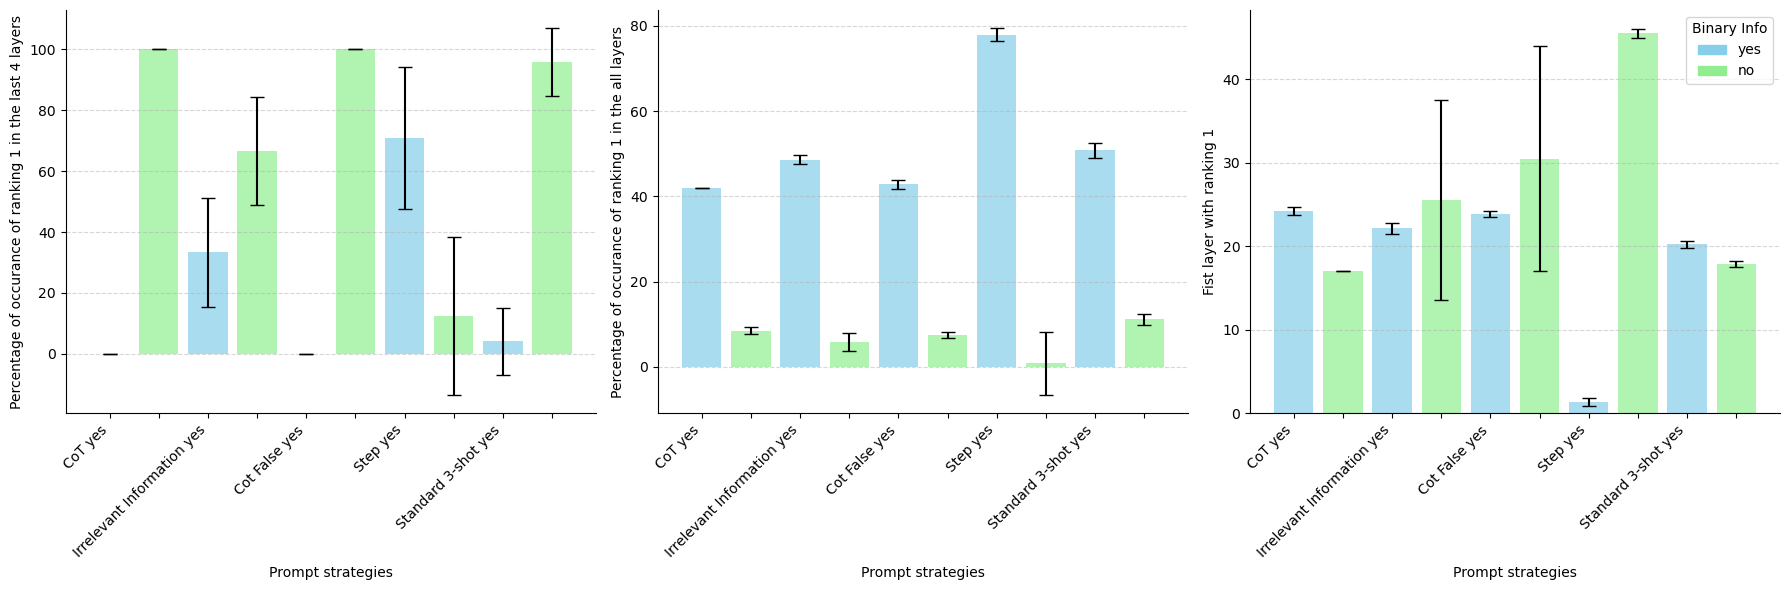

In [ ]:
# data for the three plots

categories = ['CoT yes', '', 'Irrelevant Information yes', '',
              'Cot False yes', '', 'Step yes', '' , 'Standard 3-shot yes', '' ]
bar_colors = ['skyblue', 'lightgreen', 'skyblue', 'lightgreen', 'skyblue', 'lightgreen', 'skyblue', 'lightgreen', 'skyblue',
              'lightgreen', 'skyblue', 'lightgreen', 'skyblue', 'lightgreen', 'skyblue', 'lightgreen', 'skyblue', 'lightgreen']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create three subplots in a row

# Plot 1
x_indices = np.arange(len(categories))
axes[0].bar(x_indices, last_4_layers_mean_values, yerr=last_4_layers_std_values, color=bar_colors, capsize=5, alpha=0.7)
axes[0].set_xlabel('Prompt strategies')
axes[0].set_ylabel('Percentage of occurance of ranking 1 in the last 4 layers')
axes[0].set_title('')
axes[0].set_xticks(x_indices)
axes[0].set_xticklabels(categories, rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.5)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# Plot 2 (Replace with your second set of data)
axes[1].bar(x_indices, all_layers_mean_values, yerr=all_layers_std_values, color=bar_colors, capsize=5, alpha=0.7)
axes[1].set_xlabel('Prompt strategies')
axes[1].set_ylabel('Percentage of occurance of ranking 1 in the all layers')
axes[1].set_title('')
axes[1].set_xticks(x_indices)
axes[1].set_xticklabels(categories, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# Plot 3 (Replace with your third set of data)
axes[2].bar(x_indices, first_layer_mean_values, yerr=first_layer_std_values, capsize=5, color=bar_colors, alpha=0.7)
axes[2].set_xlabel('Prompt strategies')
axes[2].set_ylabel('Fist layer with ranking 1')
axes[2].set_title('')
axes[2].set_xticks(x_indices)
axes[2].set_xticklabels(categories, rotation=45, ha='right')
axes[2].grid(axis='y', linestyle='--', alpha=0.5)
axes[2].spines['top'].set_visible(False)
axes[2].spines['right'].set_visible(False)

# Create a custom legend
legend_labels = ['yes', 'no']
legend_colors = ['skyblue', 'lightgreen']

# Add the legend to the first subplot
axes[2].legend(handles=[plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors], labels=legend_labels,
               title='Binary Info', loc='upper right')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


Qualitative Observation (super interesting): 

- cot: "yes" has default ranking one starting early layers? and then potential switch in last **4** layers. 
- irrelevant: "yes" has default ranking one starting early layers? and then potential switch in last **3** layers. 
- false reasoning: Becomes extremly condfident within the layers. Basically chooses the answer ("yes") half way through and does not switch again in the later layers
- step by step: starting layer 36 very low rankings (around 50) of our answer words and then suddenly in the last 3 layers Yes and No are either ranked one or 2. (bizarre!)


Problem: 
why yes per se higher ranked in lower layers ranked? is this a feature of model or bug of dataset? 

interestingly the other tokens seem to be more obvious, with the final output token having ranking of 1 usually starting in earlier layers than for our answer word.  

How to quantfiy these observations? 

average percentage of 1 within the last 4 layers 

average percentage of 1 within the last 15 layers

average layer of first 1 ranking 

Analysis of only correct vs. incorrect answers

In [ ]:
#filter out correct answers 

#remove all incorrrect answer from the final ranking_list 
layer_rankings_lists_only_correct_yes = []
layer_rankings_lists_only_correct_no = []

#remove all correct answers from the final ranking_list 
layer_rankings_lists_only_incorrect_yes = []
layer_rankings_lists_only_incorrect_no = []

for layer_outputs_coin, layer_answer_indices, layer_rankings_list in zip(layer_outputs_coin_lists, layer_answer_indices_lists, layer_rankings_lists): 
    
    layer_rankings_list_only_corr_yes = [] 
    layer_rankings_list_only_corr_no = [] 
    layer_rankings_list_only_incorr_yes = [] 
    layer_rankings_list_only_incorr_no = [] 
    
    for layer_output, layer_answer_index, layer_rankings, answer in zip(layer_outputs_coin, layer_answer_indices, layer_rankings_list, coin_answer_list): 

        if layer_output.token_ids[0][layer_answer_index].item() == 645 or == 1400: # if token is no 
        
            gen_answer = "no"

            if gen_answer == answer:

                layer_rankings_list_only_corr_no.append(layer_rankings)

            else:
                layer_rankings_list_only_incorr_no.append(layer_rankings)
        
        else: #if answer is yes

            gen_answer = "yes"
            
            if gen_answer == answer:

                layer_rankings_list_only_corr_yes.append(layer_rankings)

            else:
                layer_rankings_list_only_incorr_yes.append(layer_rankings)
                
    layer_rankings_lists_only_correct_yes.append(layer_rankings_list_only_corr_yes)
    layer_rankings_lists_only_correct_no.append(layer_rankings_list_only_corr_no)
    layer_rankings_lists_only_incorrect_yes.append(layer_rankings_list_only_incorr_yes)
    layer_rankings_lists_only_incorrect_no.append(layer_rankings_list_only_incorr_no)
        

Functions

In [ ]:
def calculate_percentage_of_value_occ_in_layer_intverval(layer_answer_ranking, section_start, section_end, value_to_count):
    '''
    Caclculate the percentage of the occurance of ranking "value_to_count" between the section_start and section_end layers for two tokens 
        Args: 
            layer_answer_ranking: 
            section_start: integer marking the first layers between which we get the percentage 
            section_end: integer marking the last layers between which we get the percentage
            value_to_count: is the integer (i.e. the ranking) for which we calculate the percentage of its occurance 
        Returns: 
            percentage_first_column: integer representing the percentage of first token of ranking value in the range of layers   
            percentage_second_column: integer representing the percentage of second token of ranking value in the range of layers   
        '''

    count_first_column = 0
    total_first_column = 0
    count_second_column = 0
    total_second_column = 0

    for subarray in layer_answer_ranking[section_start:section_end]:
        if len(subarray) != 2:
            raise ValueError("Each subarray should contain exactly 2 integers.")
        
        if subarray[0] == value_to_count:
            count_first_column += 1
        total_first_column += 1

        if subarray[1] == value_to_count:
            count_second_column += 1
        total_second_column += 1

    percentage_first_column = (count_first_column / total_first_column) * 100.0 if total_first_column > 0 else 0.0
    percentage_second_column = (count_second_column / total_second_column) * 100.0 if total_second_column > 0 else 0.0


    return percentage_first_column, percentage_second_column


In [ ]:
def mean_percentage (layer_answer_ranking_list, section_start, section_end, value_to_count):
    percentage_last_first_list =[]
    percentage_last_second_list = []
    
    for layer_ranking in layer_answer_ranking_list: 
        percentage_first, percentage_second = calculate_percentage_of_value_occ_in_layer_intverval(layer_ranking, section_start, section_end, value_to_count)
        percentage_last_first_list.append(percentage_first)
        percentage_last_second_list.append(percentage_second)


    mean_token1 = np.mean(percentage_last_first_list)
    std_token1 = np.std(percentage_last_first_list)

    mean_token2 = np.mean(percentage_last_second_list)
    std_token2 = np.std(percentage_last_second_list)


    return mean_token1, mean_token2, std_token2, std_token1

    

In [ ]:
def find_first_layer_with_a_ranking_value(layer_answer_ranking, value_to_find):
    index_first_column = None
    index_second_column = None

    for i, subarray in enumerate(layer_answer_ranking):
        if len(subarray) != 2:
            raise ValueError("Each subarray should contain exactly 2 integers.")
        
        if subarray[0] == value_to_find and index_first_column is None:
            index_first_column = i

        if subarray[1] == value_to_find and index_second_column is None:
            index_second_column = i

        # If both indices are found, you can break out of the loop
        if index_first_column is not None and index_second_column is not None:
            break

    return index_first_column, index_second_column


In [ ]:
def mean_frist_layer_with_a_ranking_value (layer_answer_ranking_list, value_to_find):
    first_layer_ranking1_token1_list = []
    first_layer_ranking1_token2_list =[]

    for layer_think_ranking in layer_answer_ranking_list: 
        first_layer_ranking1_token1, first_layer_ranking1_token2 = find_first_layer_with_a_ranking_value(layer_think_ranking, 1)
        first_layer_ranking1_token1_list.append(first_layer_ranking1_token1)
        first_layer_ranking1_token2_list.append(first_layer_ranking1_token2)

    first_layer_ranking1_token1_list = [x for x in first_layer_ranking1_token1_list if x is not None]

    first_layer_ranking1_token2_list = [x for x in first_layer_ranking1_token2_list if x is not None]


    print(first_layer_ranking1_token2_list)
    mean_first_layer_ranking1_token1 = np.mean (first_layer_ranking1_token1_list)
    std_first_layer_ranking1_token1 = np.std (first_layer_ranking1_token1_list)

    mean_first_layer_ranking1_token2 = np.mean (first_layer_ranking1_token2_list)
    std_first_layer_ranking1_token2 = np.std (first_layer_ranking1_token2_list)

    return mean_first_layer_ranking1_token1,  mean_first_layer_ranking1_token2, std_first_layer_ranking1_token1, std_first_layer_ranking1_token2
        